In [6]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [54]:
train_df[train_df['target']==0]['text'].values[0]

"What's up man?"

In [55]:
train_df[train_df['target']==1]['text'].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [56]:
count_vectorizer = feature_extraction.text.CountVectorizer()

In [57]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)

In [58]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

In [59]:
print(train_vectors[0].todense().shape)
print(test_vectors[0].todense().shape)

(1, 21637)
(1, 21637)


In [97]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_df[train_df['target']==1]['text'].values)

In [98]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [99]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [100]:
history = model.fit(x = train_df['text'].values,
                    y = train_df['target'].values,
                    batch_size = 64,
                    epochs=10,
                    verbose = 1,
                    validation_split=0.2)

Epoch 1/10
96/96 [==============================] - 7s 23ms/step - loss: 0.6855 - accuracy: 0.5670 - val_loss: 0.6717 - val_accuracy: 0.5837
Epoch 2/10
96/96 [==============================] - 1s 7ms/step - loss: 0.6574 - accuracy: 0.5670 - val_loss: 0.6311 - val_accuracy: 0.5837
Epoch 3/10
96/96 [==============================] - 1s 7ms/step - loss: 0.5908 - accuracy: 0.6010 - val_loss: 0.5347 - val_accuracy: 0.7413
Epoch 4/10
96/96 [==============================] - 1s 7ms/step - loss: 0.4963 - accuracy: 0.7668 - val_loss: 0.4778 - val_accuracy: 0.7859
Epoch 5/10
96/96 [==============================] - 1s 7ms/step - loss: 0.4538 - accuracy: 0.7946 - val_loss: 0.4601 - val_accuracy: 0.7984
Epoch 6/10
96/96 [==============================] - 1s 7ms/step - loss: 0.4264 - accuracy: 0.8097 - val_loss: 0.4486 - val_accuracy: 0.7984
Epoch 7/10
96/96 [==============================] - 1s 8ms/step - loss: 0.4107 - accuracy: 0.8190 - val_loss: 0.4490 - val_accuracy: 0.8155
Epoch 8/10
96/96 [=

In [101]:
test_target = model.predict(
    test_df['text'].values,
    batch_size=64,
    verbose=1)

51/51 [==============================] - 2s 2ms/step


In [102]:
pd.DataFrame(history.history).to_csv('history.csv')

In [103]:
predictions = []
for target in test_target:
    if target >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [106]:
submission = test_df.copy()
submission['target'] = predictions
submission[['id','target']].to_csv('submission.csv',index=False)

In [6]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history[metric])
  plt.plot(history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

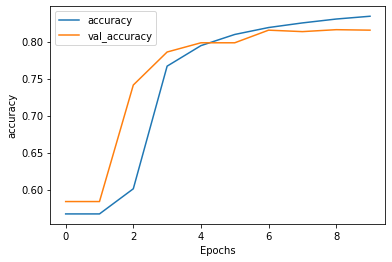

In [7]:
history = pd.read_csv('history.csv')
plot_graphs(history, 'accuracy')